**BrainStation Final Project:**

What is the project?
The project aims to analyze how a stock will react to volatility in the market, in particularly other stocks in the market. The dataset was gathered by scraping each of the 30 stocks in the Dow Jones Industrial Average from Yahoo Finance, as it features major stocks in almost every single industry, hence provide a great representation of the market. Furthermore, these companies are also generally well established, and have had a long standing history of being a public company, hence has plenty of data to analyze.

The inspiration for this project came from one of my friends who interned at the Canadian Pension Plan Investment Board as a quantitative analyst. He told me that at his work that volatility, regardless of up or down is a major factor, in fact most quant firms or hedge funds have an entire division dedicated to monitoring and perdicting volatility.

In [0]:
# gathering the appropriate dataset
! git clone https://github.com/shane200195/Stock_ml.git

Cloning into 'Stock_ml'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (606/606), done.
remote: Compressing objects: 100% (598/598), done.
remote: Total 606 (delta 14), reused 600 (delta 8), pack-reused 0
Receiving objects: 100% (606/606), 23.46 MiB | 19.02 MiB/s, done.
Resolving deltas: 100% (14/14), done.


Yahoo Finance has a very clean dataset, and little cleaning was needed. For the scraping and reformatting script, look in the cloned github folder, under "Data Collection/Formatting Scripts"

In [0]:
import pandas as pd
import numpy as np

#google was not used in the djia dataset as Google was created significantly later than the other companies, incorporating it would have led to a loss of more than 1000 data points
djia = pd.read_csv("Stock_ml/djia_no_google.csv")
djia = djia.set_index("Date")


for column in djia.columns:
  djia[column + "Volatile?"] = [1 if abs(i) > 0.01 else 0 for i in djia[column]]

# feature selection
target = "MSFT" # stock we want to test correlation with
features = [i for i in djia.columns if "Volatile?" in i and target not in i] #selecting the columns with volatility

x = djia.loc[:,features].values
#selecting the target that will be used to classify a particular state
result = djia[target + "Volatile?"].values

#testing to see if the data fits
print(djia.loc["2006-01-03":"2006-01-25", "JNJVolatile?"])

Date
2006-01-03    0
2006-01-04    1
2006-01-05    0
2006-01-06    0
2006-01-09    0
2006-01-10    0
2006-01-11    0
2006-01-12    0
2006-01-13    0
2006-01-17    0
2006-01-18    0
2006-01-19    0
2006-01-20    0
2006-01-23    0
2006-01-24    1
2006-01-25    1
Name: JNJVolatile?, dtype: int64


Basic PCA to visualize the dataset better

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

print(principal_components)

[[ 1.37725065 -0.57925166]
 [ 1.30378086 -0.0776373 ]
 [ 1.9080097  -0.07350059]
 ...
 [-0.81789889  0.16511497]
 [ 1.18586014  0.83637335]
 [ 1.29765686  0.63996441]]


In [0]:
principalDf = pd.DataFrame(data = principal_components
             , columns = ['component 1', 'component 2'])

# converting the index of result
result = pd.DataFrame(data = result, columns=["Result"])
finalDf = pd.concat([principalDf, result], axis = 1)
print(finalDf)

      component 1  component 2  Result
0        1.377250    -0.706294       1
1        1.303780    -0.095382       0
2        1.908010    -0.203587       1
3        1.045534     0.198446       0
4        0.993900     0.119367       0
...           ...          ...     ...
5133    -0.695923    -0.269550       0
5134    -0.855045     0.339990       1
5135    -0.817900     0.193427       0
5136     1.185860     0.986408       1
5137     1.297656     0.534300       1

[5138 rows x 3 columns]


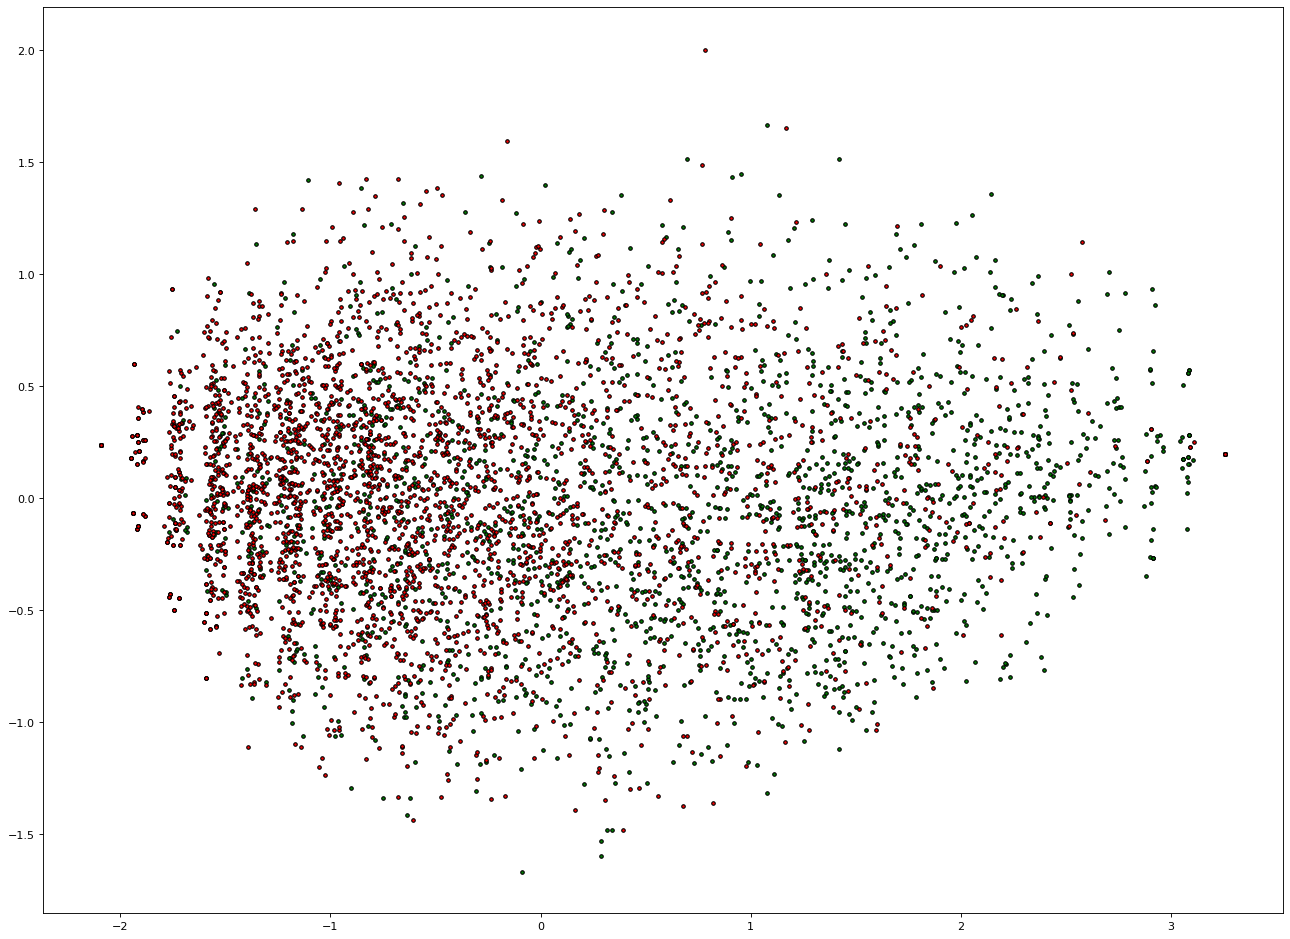

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
targets = [1, 0]
colors = ['g', 'r']

# graphing the data after PCA, the red color represents a 0 (low volatility), while the green represents a 1 (high volatility)
for target, color in zip(targets, colors):
  indicesToKeep = finalDf["Result"] == target
  plt.scatter(finalDf.loc[indicesToKeep, 'component 1']
               , finalDf.loc[indicesToKeep, 'component 2']
               , c = color
               , s = 10, edgecolor="k")
# plt.scatter(principalDf["component 1"], principalDf["component 2"])
plt.show()


Training SVM model for DJIA dataset

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

SVM_djia = SVC(gamma="auto")

# uses all stocks
X_train, X_test, y_train, y_test = train_test_split(x, result, test_size=0.33, random_state=42)

# stocks that have been component reduced
#X_train, X_test, y_train, y_test = train_test_split(finalDf.loc[:, ['component 1', 'component 2']].values, result, test_size=0.5, random_state=42)

SVM_djia.fit(X_train, y_train)

print(SVM_djia.score(X_train, y_train))
print(SVM_djia.score(X_test, y_test))





0.7321324811156305
0.7293632075471698


Training a KNN model for DJIA dataset

In [0]:
from sklearn.neighbors import KNeighborsClassifier

KNN_djia = KNeighborsClassifier(n_neighbors=10)
KNN_djia.fit(X_train, y_train)
#predictions = KNN_sp500.predict(X_test)
#accuracy_score(predictions, y_test)
print(KNN_djia.score(X_train, y_train))
print(KNN_djia.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


0.7416201117318436
0.7436260623229461


Logistic Regression for DJIA dataset

In [0]:
from sklearn.linear_model import LogisticRegression

LR_djia = LogisticRegression()
LR_djia.fit(X_train, y_train)

print(LR_djia.score(X_train, y_train))
print(LR_djia.score(X_test, y_test))



0.7402234636871509
0.7563739376770539


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random Forest Classfier

In [0]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(max_depth = 5)
RFC.fit(X_train, y_train)

print(RFC.score(X_train, y_train))
print(RFC.score(X_test, y_test))


0.7611731843575419
0.7535410764872521


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [0]:
X_train = x[:split]
Y_train = result[:split]

X_test = x[split:]
Y_test = result[split:]

X_train_t = X_train[:, None]
X_test_t = X_test[:, None]
print(X_train[0].shape)

(29,)


Now we will try to build a recurrent neural network, with LSTM to see if it can fit the data better. (Only Dense and LSTM layers are used)

In [0]:
# we need to segregate the new data
split = 4000

X_train = x[:split]
Y_train = result[:split]

X_test = x[split:]
Y_test = result[split:]

#importing the modules needed for the neural network
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, GRU


X_train_t = X_train[:, None]
X_test_t = X_test[:, None]
K.clear_session()

model = Sequential()

model.add(Dense(1, input_shape=(1, 29)))
model.add(LSTM(6, input_shape=(1, 29)))
model.add(Dense(1))


#Using Keras Callback
ES = EarlyStopping(monitor='val_loss')

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_t, Y_train,
         epochs=10, batch_size=1, verbose=1, callbacks=[ES], validation_data = (X_test_t, Y_test))

#model.fit(X_train_t, Y_train,
#         epochs=4, batch_size=1, verbose=1, validation_data = (X_test_t, Y_test))

y_train_lstm = model.predict_classes(X_train_t)
y_test_lstm = model.predict_classes(X_test_t)

print(accuracy_score(Y_train, y_train_lstm))
print(accuracy_score(Y_test, y_test_lstm))



"""
WE WILL USE THIS SECTION TO SEE HOW OUR MODEL VARIES:

OLD DATA:
loss = "mean_squared_error", 2500/519 split
Train: 0.7256
Test: 0.7880539499036608

loss = "mean_squared_error", 2500/519 split, lstm-units = 10
Train: 0.7276
Test: 0.7976878612716763

loss = "mean_absolute_error", 2500/519 split
Train: 0.726
Test: 0.7861271676300579


NEW DATA (Added 2000 more sets of data):
loss = "mean_squared_error", epochs = CallBack-EarlyStopping, 3500/1638 split, lstm-units = 6, layers: LSTM-Dense

model.add(LSTM(6, input_shape=(1, 29)))
model.add(Dense(1))

Train: 0.714
Test: 0.7472527472527473

loss = "mean_squared_error", epochs = CallBack-EarlyStopping, 3500/1638 split, lstm-units = 6, layers: Dense-LSTM-Dense

model.add(Dense(1, input_shape=(1, 29)))
model.add(LSTM(6, input_shape=(1, 29)))
model.add(Dense(1))

Train: 0.712
Test: 0.7490842490842491

4000/1138 split:
Train: 0.7105
Test: 0.7601054481546573

loss = "mean_squared_error", epochs = CallBack-EarlyStopping, 3500/1638 split, lstm-units = 6, layers: Dense-Dense

model.add(Dense(1, input_shape=(29,)))
model.add(Dense(1))

Train: 0.7088571428571429
Test: 0.7478632478632479




"""


Using TensorFlow backend.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4000 samples, validate on 1138 samples
Epoch 1/10





4000/4000 [==============================] - 10s 3ms/step - loss: 0.2133 - val_loss: 0.1775
Epoch 2/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.2001 - val_loss: 0.1717
Epoch 3/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.1976 - val_loss: 0.1695
Epoch 4/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.1963 - val_loss: 0.1810
0.6935
0.7539543057996485


'\nWE WILL USE THIS SECTION TO SEE HOW OUR MODEL VARIES:\n\nOLD DATA:\nloss = "mean_squared_error", 2500/519 split\nTrain: 0.7256\nTest: 0.7880539499036608\n\nloss = "mean_squared_error", 2500/519 split, lstm-units = 10\nTrain: 0.7276\nTest: 0.7976878612716763\n\nloss = "mean_absolute_error", 2500/519 split\nTrain: 0.726\nTest: 0.7861271676300579\n\n\nNEW DATA (Added 2000 more sets of data):\nloss = "mean_squared_error", epochs = CallBack-EarlyStopping, 3500/1638 split, lstm-units = 6, layers: LSTM-Dense\n\nmodel.add(LSTM(6, input_shape=(1, 29)))\nmodel.add(Dense(1))\n\nTrain: 0.714\nTest: 0.7472527472527473\n\nloss = "mean_squared_error", epochs = CallBack-EarlyStopping, 3500/1638 split, lstm-units = 6, layers: Dense-LSTM-Dense\n\nmodel.add(Dense(1, input_shape=(1, 29)))\nmodel.add(LSTM(6, input_shape=(1, 29)))\nmodel.add(Dense(1))\n\nTrain: 0.712\nTest: 0.7490842490842491\n\n4000/1138 split:\nTrain: 0.7105\nTest: 0.7601054481546573\n\nloss = "mean_squared_error", epochs = CallBack-Ea

Instead of LSTM, we will try with GRU

In [0]:
K.clear_session()
model = Sequential()

model.add(Dense(1, input_shape=(1, 29)))
model.add(GRU(5, input_shape=(1, 29)))
model.add(Dense(1))

ES = EarlyStopping(monitor='val_loss')

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_t, Y_train,
         epochs=10, batch_size=1, verbose=1, callbacks=[ES], validation_data = (X_test_t, Y_test))

#model.fit(X_train_t, Y_train,
#         epochs=4, batch_size=1, verbose=1, validation_data = (X_test_t, Y_test))

y_train_lstm = model.predict_classes(X_train_t)
y_test_lstm = model.predict_classes(X_test_t)

print(accuracy_score(Y_train, y_train_lstm))
print(accuracy_score(Y_test, y_test_lstm))


"""
loss = "mean_squared_error", epochs = CallBack-EarlyStopping, 4000/1138 split, gru-units = 6, layers: GRU-Dense

model.add(GRU(6, input_shape=(1, 29)))
model.add(Dense(1))

Train: 0.72225
Test: 0.76274165


loss = "mean_squared_error", epochs = CallBack-EarlyStopping, 4000/1138 split, gru-units = 6, layers: Dense-GRU-Dense

model.add(Dense(1, input_shape=(1, 29)))
model.add(GRU(5, input_shape=(1, 29)))
model.add(Dense(1))

Train: 0.71075
Test: 0.7609841827768014


"""

Train on 4000 samples, validate on 1138 samples
Epoch 1/10
4000/4000 [==============================] - 10s 2ms/step - loss: 0.2197 - val_loss: 0.1684
Epoch 2/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.1998 - val_loss: 0.1675
Epoch 3/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.1971 - val_loss: 0.1668
Epoch 4/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.1967 - val_loss: 0.1663
Epoch 5/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.1958 - val_loss: 0.1664
0.71075
0.7609841827768014


'\nloss = "mean_squared_error", epochs = CallBack-EarlyStopping, 4000/1138 split, gru-units = 6, layers: GRU-Dense\n\nmodel.add(GRU(6, input_shape=(1, 29)))\nmodel.add(Dense(1))\n\nTrain: 0.72225\nTest: 0.76274165\n\n\nloss = "mean_squared_error", epochs = CallBack-EarlyStopping, 4000/1138 split, gru-units = 6, layers: Dense-GRU-Dense\n\nmodel.add(Dense(1, input_shape=(1, 29)))\nmodel.add(GRU(5, input_shape=(1, 29)))\nmodel.add(Dense(1))\n\n\n\n'